## Cloning the repository and importing required modules

Cloning the repository containing the YOLOv1 “from scratch” implementation from GitHub and navigate to the project folder.

We then import:

- YOLOv1: the YOLOv1 model class.
- yolo_loss: the YOLOv1-specific loss function.
- YoloDataset: a custom dataset class for loading YOLO images and labels.
- src.utils: various utility functions for processing and visualization.
- torch and DataLoader: for handling tensors and batching data with PyTorch.

In [14]:
!git clone https://github.com/LucasAurouet/yolov1-from-scratch.git

%cd yolov1-from-scratch

from src.yolo_model import YOLOv1
from src.loss import yolo_loss
from src.dataloader import YoloDataset
import src.utils
import torch
from torch.utils.data import DataLoader

Cloning into 'yolov1-from-scratch'...
remote: Enumerating objects: 180, done.
remote: Counting objects: 100% (180/180), done.
remote: Compressing objects: 100% (123/123), done.
remote: Total 180 (delta 115), reused 121 (delta 56), pack-reused 0 (from 0)
Receiving objects: 100% (180/180), 565.73 KiB | 15.71 MiB/s, done.
Resolving deltas: 100% (115/115), done.
/kaggle/working/yolov1-from-scratch/yolov1-from-scratch


## Setting the device for training

Checking if a GPU is available for PyTorch and set the computation device accordingly.

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('device:', device)

device: cuda


## Defining the YOLOv1 configuration

Main hyperparameters for the YOLOv1 model:

- S: the number of grid cells along each image dimension (7 × 7 grid).
- B: the number of bounding boxes predicted per grid cell (2 in this case).
- C: the number of classes in the dataset (52).

In [16]:
config = {
    'S': 7,
    'B': 2,
    'C': 52,
}

## Initializing the YOLOv1 model

Creating an instance of the YOLOv1 model using the configuration defined earlier.

YOLOv1(**config) unpacks the config dictionary and passes the hyperparameters (S, B, C).

model.to(device) moves the model to the selected computation device (GPU or CPU) so that all subsequent tensor operations and training steps occur on the correct hardware.

In [17]:
model = YOLOv1(**config)
model = model.to(device)

## Creating the dataset and visualizing an example

Initializing our custom YOLO dataset:

data_dir points to the folder containing the training images and their corresponding label files.

YoloDataset(data_dir, config) creates a dataset object that will handle loading images, reading label files, and converting annotations into YOLOv1 tensors.

We then retrieve a single example from the dataset:

example_img, example_label = dataset.\_\_getitem\_\_(0) gets the first image and its corresponding label tensor.
src.utils.draw_output displays the image along with the bounding boxes and class labels.

- The t=0.0 argument controls the confidence threshold for drawing boxes (here set to 0 to show all boxes).
- transform=False ensures we visualize the raw image without any additional preprocessing.

tensor([0.7368, 0.9312, 0.0625, 0.0569, 1.0000, 0.7368, 0.9312, 0.0625, 0.0569,
        1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


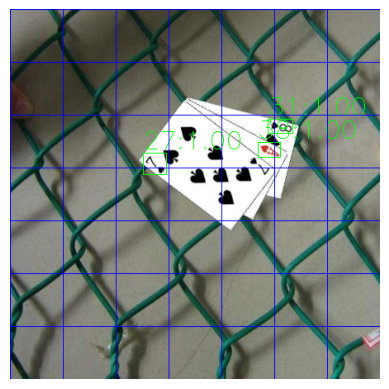

In [18]:
data_dir = r'/kaggle/input/playing-cards-darknet/test'

dataset = YoloDataset(data_dir, config)

example_img, example_label = dataset.__getitem__(0)
print(example_label[2,2,...])
src.utils.draw_output(example_img, example_label, t=0.0, config=config, transform=False)

## Optimizer configuration

In [19]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
    weight_decay=5e-4
)

## Training the YOLOv1 model

Setting up up and runnin a training loop for YOLOv1:

DataLoader wraps the YoloDataset to provide mini-batches of data with parallel loading (num_workers) for efficiency.

pin_memory=True can speed up GPU transfers for CUDA-enabled devices.

yolo_loss(...) calculates the YOLOv1 loss, taking into account coordinate loss (lambda_coord=5) and no-object confidence penalty (lambda_noobj=0.5).

In [24]:
epochs = 100

dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)

model.train()

for epoch in range(epochs):
    for images_batch, labels_batch in dataloader:
        images_batch = images_batch.to(device)
        labels_batch = labels_batch.to(device)
        
        output_batch = model.forward(images_batch)
        loss = yolo_loss(output_batch, labels_batch, S=7, B=2, C=52, lambda_coord=5, lambda_noobj=0.5)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

Epoch 1/100, Loss: 6.0662
Epoch 2/100, Loss: 5.7861
Epoch 3/100, Loss: 5.5385
Epoch 4/100, Loss: 5.8499
Epoch 5/100, Loss: 5.7510
Epoch 6/100, Loss: 5.9270
Epoch 7/100, Loss: 6.3387
Epoch 8/100, Loss: 5.9528
Epoch 9/100, Loss: 5.9688
Epoch 10/100, Loss: 5.9404
Epoch 11/100, Loss: 6.4401
Epoch 12/100, Loss: 5.5028
Epoch 13/100, Loss: 5.9088
Epoch 14/100, Loss: 5.4376
Epoch 15/100, Loss: 5.4625
Epoch 16/100, Loss: 6.3471
Epoch 17/100, Loss: 5.9246
Epoch 18/100, Loss: 6.1197
Epoch 19/100, Loss: 6.0030
Epoch 20/100, Loss: 5.9423
Epoch 21/100, Loss: 6.1399
Epoch 22/100, Loss: 5.9826
Epoch 23/100, Loss: 6.3657
Epoch 24/100, Loss: 6.4037
Epoch 25/100, Loss: 6.0603
Epoch 26/100, Loss: 5.8355
Epoch 27/100, Loss: 6.3422
Epoch 28/100, Loss: 5.2960
Epoch 29/100, Loss: 6.1142
Epoch 30/100, Loss: 5.6788
Epoch 31/100, Loss: 6.1400
Epoch 32/100, Loss: 5.6185
Epoch 33/100, Loss: 5.8676
Epoch 34/100, Loss: 5.4357
Epoch 35/100, Loss: 6.0561
Epoch 36/100, Loss: 5.8562
Epoch 37/100, Loss: 6.2464
Epoch 38/1

In [29]:
example_img, example_label = dataset.__getitem__(0)

example_label = example_label.to(device)
example_img = example_img.unsqueeze(0).to(device)

epochs = 100
for epoch in range(epochs):
    
    pred = model.forward(example_img)
    loss = yolo_loss(pred, example_label, S=7, B=2, C=52, lambda_coord=5, lambda_noobj=0.5)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    

Epoch 1/100, Loss: 0.0056
Epoch 2/100, Loss: 0.0054
Epoch 3/100, Loss: 0.0054
Epoch 4/100, Loss: 0.0053
Epoch 5/100, Loss: 0.0051
Epoch 6/100, Loss: 0.0049
Epoch 7/100, Loss: 0.0049
Epoch 8/100, Loss: 0.0051
Epoch 9/100, Loss: 0.0056
Epoch 10/100, Loss: 0.0083
Epoch 11/100, Loss: 0.0134
Epoch 12/100, Loss: 0.0421
Epoch 13/100, Loss: 0.0075
Epoch 14/100, Loss: 0.0803
Epoch 15/100, Loss: 0.1156
Epoch 16/100, Loss: 0.1640
Epoch 17/100, Loss: 0.1578
Epoch 18/100, Loss: 0.1455
Epoch 19/100, Loss: 0.1309
Epoch 20/100, Loss: 0.1161
Epoch 21/100, Loss: 0.1024
Epoch 22/100, Loss: 0.0917
Epoch 23/100, Loss: 0.0835
Epoch 24/100, Loss: 0.0786
Epoch 25/100, Loss: 0.0743
Epoch 26/100, Loss: 0.0710
Epoch 27/100, Loss: 0.0665
Epoch 28/100, Loss: 0.0607
Epoch 29/100, Loss: 0.0532
Epoch 30/100, Loss: 0.0449
Epoch 31/100, Loss: 0.0493
Epoch 32/100, Loss: 0.0407
Epoch 33/100, Loss: 0.0312
Epoch 34/100, Loss: 0.0393
Epoch 35/100, Loss: 0.0293
Epoch 36/100, Loss: 0.0328
Epoch 37/100, Loss: 0.0645
Epoch 38/1

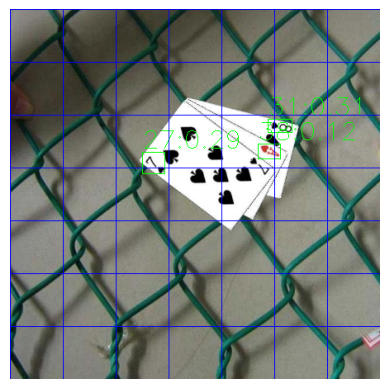

In [30]:
model.eval()

test_img, test_label = dataset.__getitem__(0)

test_tensor = test_img.unsqueeze(0).to(device)
output = model(test_tensor).squeeze(0)

src.utils.draw_output(test_img, output, t=0.01, config=config, transform=True)